# Two-dimensional inviscid Burgers equation

## Governing equation

The two-dimensional inviscid Burgers equation follows from the 1D version solved earlier:
$$ \dfrac{\partial \mathbf{U}}{\partial t} + \mathbf{U} \dfrac{\partial \mathbf{U}}{\partial \mathbf{x}} = 0 $$

where 

$$ \mathbf{U} = \left( \begin{array}{c} u \\ v \end{array} \right) $$
is the 2D velocity vector and 
$$ \mathbf{x} = \left( \begin{array}{c} x \\ y \end{array} \right) $$
is the 2D spatial coordinate vector. This equation represents a coupled, non-linear system of two equations in two dimensions:
\begin{align}
\dfrac{\partial u}{\partial t} + u \dfrac{\partial u}{\partial x} + v \dfrac{\partial u}{\partial y} &= 0 \\
\dfrac{\partial v}{\partial t} + u \dfrac{\partial v}{\partial x} + v \dfrac{\partial v}{\partial y} &= 0 
\end{align}

These equations are obviously non-linear due to the variable coefficients in the spatial derivative terms. They are also obviously coupled, as both equation contain both $u$ and $v$ terms in them.

## Numerical methods

### First-order upwind

The simplest method for solving the 2D inviscid Burgers equation is the _first-order upwind_ method, where we approximate the temporal derivative with a forwards difference and the spatial derivatives with a backwards difference, yielding
\begin{align}
\dfrac{u_{i,j}^{n+1} - u_{i,j}^n}{\Delta t} + u_{i,j}^n \dfrac{u_{i,j}^n - u_{i-1,j}^n}{\Delta x} + v_{i,j}^n \dfrac{u_{i,j}^n - u_{i,j-1}^n}{\Delta y} &=0 \\
\dfrac{v_{i,j}^{n+1} - v_{i,j}^n}{\Delta t} + u_{i,j}^n \dfrac{v_{i,j}^n - v_{i-1,j}^n}{\Delta x} + v_{i,j}^n \dfrac{v_{i,j}^n - v_{i,j-1}^n}{\Delta y} &=0
\end{align}
Moving the only unknown term (i.e. the $n+1$ time terms) in the above equations to the LHS and all the known terms (i.e. the $n$ time terms) to the RHS yields a simple explicit expression for the 2D velocity at the new time level:
\begin{align}
u_{i,j}^{n+1}  &= u_{i,j}^n - u_{i,j}^n \dfrac{\Delta t}{\Delta x}(u_{i,j}^n - u_{i-1,j}^n) - v_{i,j}^n \dfrac{\Delta t}{\Delta y}(u_{i,j}^n - u_{i,j-1}^n) \\
v_{i,j}^{n+1}  &= v_{i,j}^n - u_{i,j}^n \dfrac{\Delta t}{\Delta x}(v_{i,j}^n - v_{i-1,j}^n) - v_{i,j}^n \dfrac{\Delta t}{\Delta y}(v_{i,j}^n - v_{i,j-1}^n).
\end{align}

This first-order upwind method is first-order accurate in time and space. Being first-order, we expect that it will experience dissipation error.

### MacCormack method

To increase the order of accuracy, a two-step method such as the MacCormack predictor-corrector method, can be employed. For the MacCormack method, we will begin with the conservation form of the governing equation:
$$ 
\dfrac{\partial \mathbf{U}}{\partial t} + \dfrac{\partial \mathbf{F}}{\partial x} + \dfrac{\partial \mathbf{G}}{\partial y} = 0
$$                                                                             where
$$
\mathbf{U} = \left( \begin{array}{c}
                    u \\
                    v 
                    \end{array}
             \right)
             \qquad
\mathbf{F} = \left( \begin{array}{c}
                    \frac{u^2}{2} \\
                    \frac{uv}{2}
                    \end{array}
             \right)  
             \qquad
\mathbf{G} = \left( \begin{array}{c}
                    \frac{uv}{2} \\
                    \frac{v^2}{2}
                    \end{array}
             \right).              
$$
MacCormack is a two-step method:

__Predictor:__
$$
\overline{\mathbf{U}_{i,j}^{n+1}} = \mathbf{U}_{i,j}^{n} - \dfrac{\Delta t}{\Delta x} (\mathbf{F}^n_{i+1,j} - \mathbf{F}^n_{i,j}) - \dfrac{\Delta t}{\Delta y} (\mathbf{G}^n_{i,j+1} - \mathbf{G}^n_{i,j})
$$

__Corrector:__
$$
\mathbf{U}^{n+1}_{i,j} = \dfrac{1}{2} \left( \mathbf{U}^n_{i,j} + \overline{\mathbf{U}^{n+1}_{i,j}} - \dfrac{\Delta t}{\Delta x} (\overline{\mathbf{F}^{n+1}_{i,j}} - \overline{\mathbf{F}^{n+1}_{i-1,j}}) - \dfrac{\Delta t}{\Delta y} (\overline{\mathbf{G}^{n+1}_{i,j}} - \overline{\mathbf{G}^{n+1}_{i,j-1}}) \right)
$$
The predictor step is conducted using a forwards difference. The corrector step is conducted using a backwards difference.

## Python code

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

### Function declations

First, we define a number of functions.

The first initializes the velocity field with a hat function:

In [101]:
def initialize(nx, ny, dx, dy):
    # assign initial conditions 
    # set hat function such that u(0.5<=x<=1 && 0.5<=y<=1) is 2
    u = np.ones((ny,nx))
    v = np.ones((ny,nx))
    u[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    # set hat function such that v(0.5<=x<=1 && 0.5<=y<=1) is 2
    v[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2    
    return u,v

The next function generates a 3D surface plot of the computed velocity field:

In [102]:
def plot2d(x,y,u,figtitle):
    # This function yields a pretty 3D plot of a 2D field. It takes three
    # arguments: the x array of dimension (1,nx), y arrary of dim (1,ny), and 
    # solution array of dimension (ny,nx)
    
    fig = plt.figure(figsize=(11, 7), dpi=100)
    ax = fig.gca(projection='3d')
    X, Y = np.meshgrid(x, y)
    ax.plot_surface(X, Y, u, cmap=cm.viridis, rstride=2, cstride=2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')   
    ax.set_title(figtitle)

This function computes the solution of the 2D inviscid Burgers equation by integrating in time using the first-order upwind method:

In [103]:
def upwind(u,v,dt,dx,dy,nt):
    # This function solves 2D inviscid Burgers equation in 2D using
    # first-order upwind method. It takes 5 arguments: the initial u and 
    # v arrays, time step size, spatial step size in x, spatial step size 
    # in y, and the number of time steps to integrate.
    
    # loop across time steps
    fig = plt.figure(figsize=(11,7), dpi=100)
    plt.title('Upwind')
    for n in range (0, nt + 1):
        un = u.copy()  # un and vn are the u and v fields at time n
        vn = v.copy()  
        u[1:, 1:] = un[1:,1:] \
                    - (un[1:,1:]*dt/dx*(un[1:,1:]-un[1:,:-1])) \
                    - (vn[1:,1:]*dt/dy*(un[1:,1:]-un[:-1,1:]))
        v[1:, 1:] = vn[1:,1:] \
                    - (un[1:,1:]*dt/dx*(vn[1:,1:]-vn[1:,:-1])) \
                    - (vn[1:,1:]*dt/dy*(vn[1:,1:]-vn[:-1,1:]))
        u[0,:] = 1
        u[-1,:] = 1
        u[:,0] = 1
        u[:,-1] = 1
        v[0,:] = 1
        v[-1,:] = 1
        v[:,0] = 1
        v[:,-1] = 1
        
        if (n % 20 == 0):
            string = 'n =' + str(n)
            plt.plot(x,u[70,:],label=string)
            plt.legend()
    
    return u,v

This function computes the solution of the 2D inviscid Burgers equation, integrating in time using the second-order MacCormack scheme:

In [104]:
def maccormack(u,v,dt,dx,dy,nt):
    # This function solves 2D inviscid Burgers equation in 2D using
    # MacCormack method. It takes 5 arguments: the initial u and v arrays,
    # time step size, x spatial step size dx, y spatial step size dy, and
    # number of time steps to integrate.
    fig = plt.figure(figsize=(11, 7), dpi=100)    
    plt.title('MacCormack2')
    
    # loop across time steps
    for n in range (nt + 1):
        up = u.copy()
        vp = v.copy()
        
        # Predictor step - forwards difference
        F = 0.5*u.copy()**2
        G = 0.5*u.copy()*v.copy()
        H = 0.5*v.copy()**2
        up[1:-1,1:-1] = u[1:-1,1:-1] - dt/dx*(F[1:-1,2:]-F[1:-1,1:-1]) - dt/dy*(G[2:,1:-1]-G[1:-1,1:-1]) 
        vp[1:-1,1:-1] = v[1:-1,1:-1] - dt/dx*(G[1:-1,2:]-G[1:-1,1:-1]) - dt/dy*(H[2:,1:-1]-H[1:-1,1:-1])
        
        # Corrector step - backwards difference
        Fp = 0.5*up.copy()**2
        Gp = 0.5*up.copy()*vp.copy()
        Hp = 0.5*vp.copy()**2
        u[1:-1,1:-1] = 0.5*(u[1:-1,1:-1]+up[1:-1,1:-1] - dt/dx*(Fp[1:-1,1:-1]-Fp[1:-1,0:-2]) - dt/dy*(Gp[1:-1,1:-1]-Gp[0:-2,1:-1]))
        v[1:-1,1:-1] = 0.5*(v[1:-1,1:-1]+vp[1:-1,1:-1] - dt/dx*(Gp[1:-1,1:-1]-Gp[1:-1,0:-2]) - dt/dy*(Hp[1:-1,1:-1]-Hp[0:-2,1:-1]))
             
        u[0,:] = 1
        u[-1,:] = 1
        u[:,0] = 1
        u[:,-1] = 1
        v[0,:] = 1
        v[-1,:] = 1
        v[:,0] = 1
        v[:,-1] = 1
        
        if (n % 20 == 0):
            string = 'n=' + str(n)
            plt.plot(x,u[70,:],label=string)
            plt.legend()
        
    return u, v

### Main program

The main program defines solution parameters:

In [105]:
# define parameters
Lx = 2.
Ly = 2.
nx = 151
ny = 151
nt = 300
dx = Lx / (nx-1)
dy = Ly / (ny-1)
sigma = 0.2
dt = sigma*min(dx,dy)/2

print('dx = ', dx, ', dy = ', dy, ', dt = ', dt, 's')

dx =  0.013333333333333334 , dy =  0.013333333333333334 , dt =  0.0013333333333333335 s


Creates the mesh variable arrays:

In [106]:
# define mesh arrays
x = np.linspace(0.,Lx,nx)
y = np.linspace(0.,Ly,ny)

Initialize the velocity and plot the $u$ velocity component at $t$ = 0

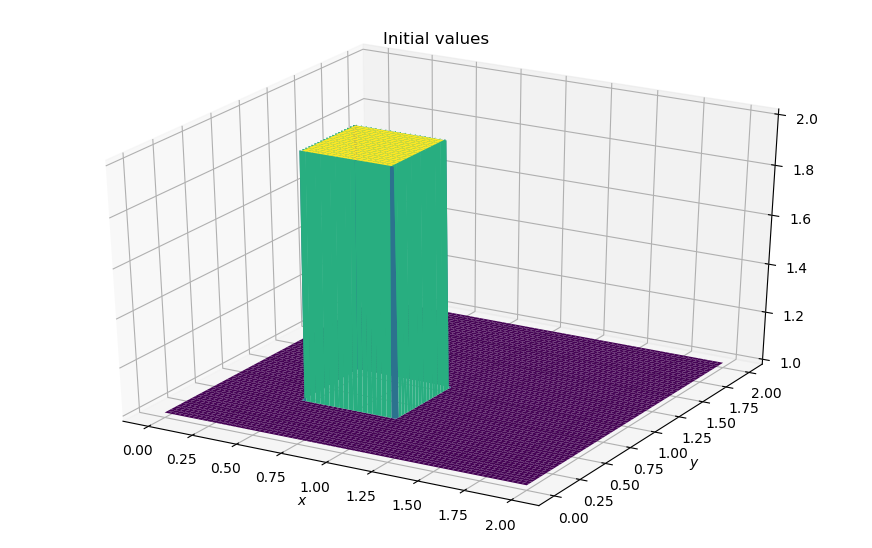

In [107]:
# define initial solution arrays
u, v = initialize(nx, ny, dx, dy)
plot2d(x, y, u, 'Initial values')

__First-order upwind method:__

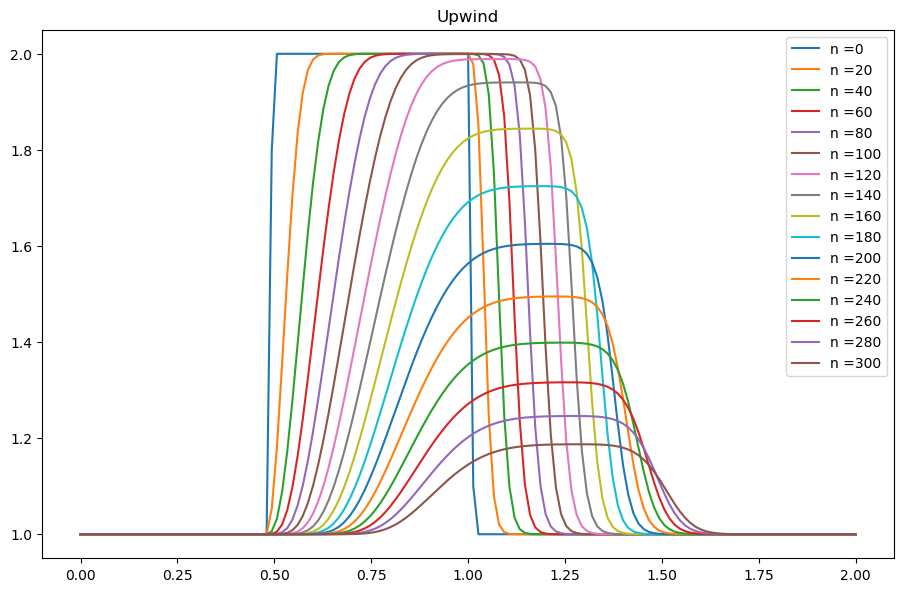

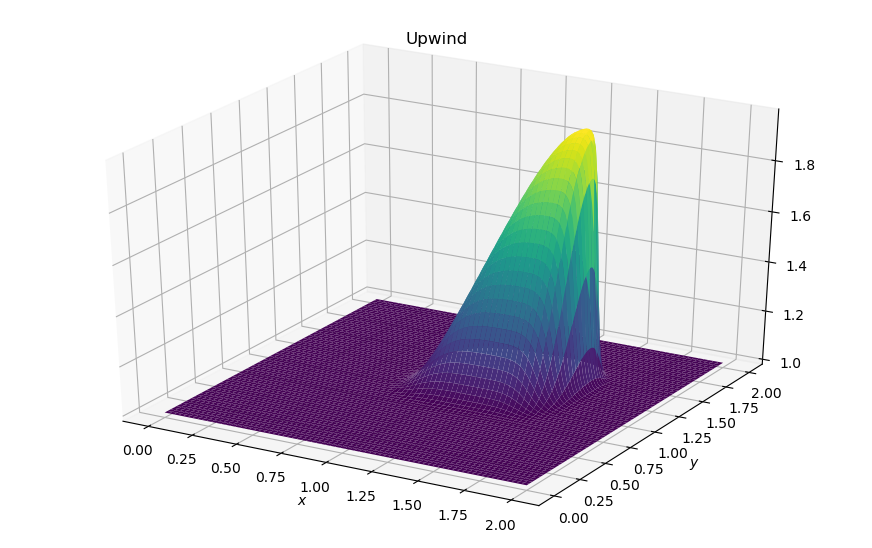

In [108]:
# Solve using upwind method 
u1, v1 = upwind(u, v, dt, dx, dy, nt)
plot2d(x, y, u1, 'Upwind')

__Second-order MacCormack method:__

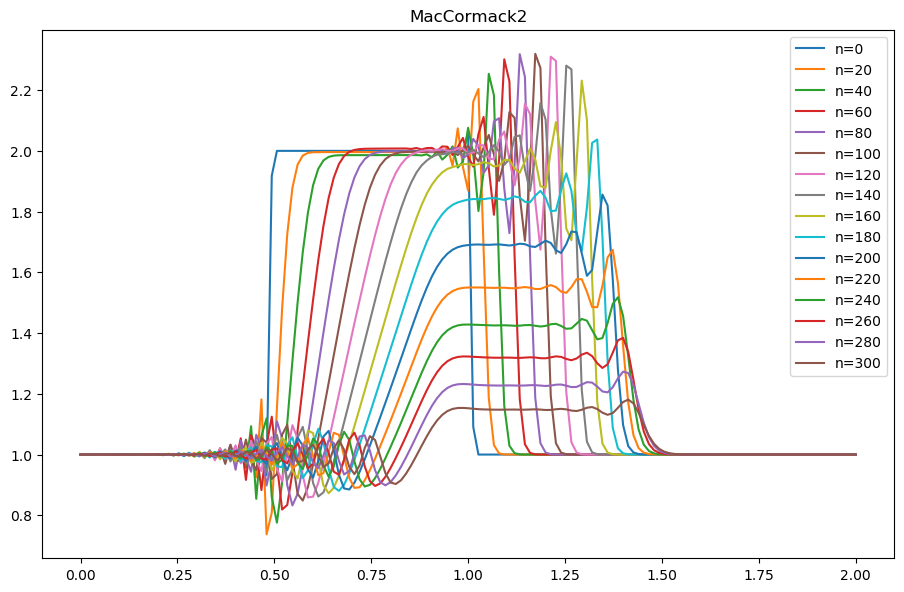

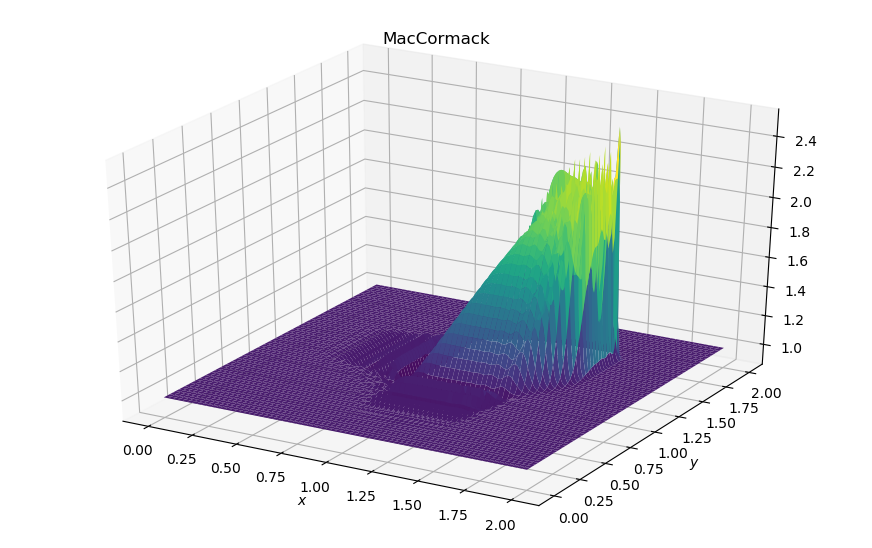

In [109]:
# Solve using MacCormack method
u, v = initialize(nx, ny, dx, dy)
u2, v2 = maccormack(u, v, dt, dx, dy, nt)
plot2d(x, y, u2, 'MacCormack')

### Comparison of first and second-order schemes

The above figures illustrate that first-order upwind scheme yields a much smoother solution than the second-order MacCormack scheme. Nonetheless, we want to compare the accuracy of the two schemes relative to each other. To do so, let's plot the solution at $y$ = 1.4 after 80 time steps.

Text(0, 0.5, '$u$')

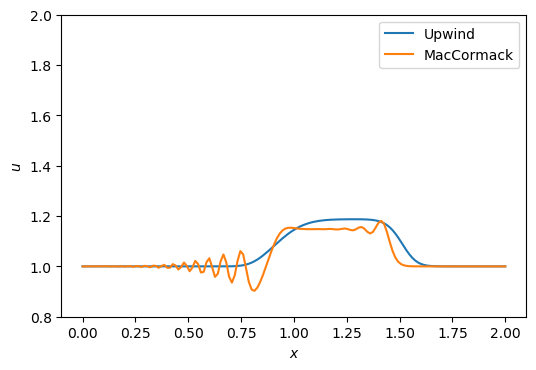

In [110]:
# Compare solution at y = 1.4
fig = plt.figure(figsize=(6, 4), dpi=100)
plt.plot(x,u1[70,:],label='Upwind')
plt.plot(x,u2[70,:],label='MacCormack')
plt.legend()
plt.ylim((0.8,2))
plt.xlabel('$x$')
plt.ylabel('$u$')

We see that the MacCormack scheme experiences dispersion error that manifests as high-frequency oscilaltions near the discontinuities. Both schemes also suffer from significant dissipation at long simulation times.

### Implementing a smoother into the MacCormack method

The high-frequency dispersion error originates from the lack of resolution in the vicinity of the discontinuity. Because the governing equation is inviscid, there is no viscous damping that can remove the oscillations. In order to improve the solution, we can add viscous damping artificially by adding a viscous term to our original MacCormack method.

Let us add a fourth-order explicit dissipation to the method in the form of:
$$ -\omega \left( (\Delta x)^4 \dfrac{\partial^4 }{\partial x^4}(\mathbf{U}^n) + (\Delta y)^4 \dfrac{\partial^4}{\partial y^4} (\mathbf{U}^n) \right)
$$
where $\omega$ is a damping coefficient that for stability must be less than $\frac{1}{16}$. Using centered differences to approximate the fourth-order terms above yields
$$
(\Delta x)^4 \dfrac{\partial^4 }{\partial x^4}(\mathbf{U}^n) \approx \mathbf{U}^n_{i+2,j} -4 \mathbf{U}^n_{i+1,j} +6 \mathbf{U}^n_{i,j} - 4\mathbf{U}^n_{i-1,j} + \mathbf{U}^n_{i-2,j} $$
$$
(\Delta y)^4 \dfrac{\partial^4 }{\partial y^4}(\mathbf{U}^n) \approx \mathbf{U}^n_{i,j+2} -4 \mathbf{U}^n_{i,j+1} +6 \mathbf{U}^n_{i,j} - 4\mathbf{U}^n_{i,j-1} + \mathbf{U}^n_{i,j-2} $$

We add this to our MacCormack scheme in both the predictor and correct steps.

In [111]:
def maccormack2(u,v,dt,dx,dy,nt):
    # This function solves 2D inviscid Burgers equation in 2D using
    # MacCormack method. It takes 5 arguments: the initial u and v arrays,
    # time step size, x spatial step size dx, y spatial step size dy, and
    # number of time steps to integrate.
    fig = plt.figure(figsize=(11, 7), dpi=100)    
    plt.title('MacCormack with smoothing')
    
    # Damping coefficient; must be below 1/16 for stability
    omega = 0.05
    
    # loop across time steps
    for n in range (nt + 1):
        up = u.copy()
        vp = v.copy()
        
        F = 0.5*u.copy()**2
        G = 0.5*u.copy()*v.copy()
        H = 0.5*v.copy()**2
        up[1:-1,1:-1] = u[1:-1,1:-1] - dt/dx*(F[1:-1,2:]-F[1:-1,1:-1]) - dt/dy*(G[2:,1:-1]-G[1:-1,1:-1]) 
        vp[1:-1,1:-1] = v[1:-1,1:-1] - dt/dx*(G[1:-1,2:]-G[1:-1,1:-1]) - dt/dy*(H[2:,1:-1]-H[1:-1,1:-1])
        
        # add smoothing
        up[2:-2,2:-2] = u[2:-2,2:-2] - omega*(u[2:-2,4:] - 4*u[2:-2,3:-1] + 6*u[2:-2,2:-2] - 4*u[2:-2,1:-3] + u[2:-2,:-4]
                                          + u[4:,2:-2] - 4*u[3:-1,2:-2] + 6*u[2:-2,2:-2] - 4*u[1:-3,2:-2] + u[:-4,2:-2])
        vp[2:-2,2:-2] = v[2:-2,2:-2] - omega*(v[2:-2,4:] - 4*v[2:-2,3:-1] + 6*v[2:-2,2:-2] - 4*v[2:-2,1:-3] + v[2:-2,:-4]
                                          + v[4:,2:-2] - 4*v[3:-1,2:-2] + 6*v[2:-2,2:-2] - 4*v[1:-3,2:-2] + v[:-4,2:-2])
        
        Fp = 0.5*up.copy()**2
        Gp = 0.5*up.copy()*vp.copy()
        Hp = 0.5*vp.copy()**2
        u[1:-1,1:-1] = 0.5*(u[1:-1,1:-1]+up[1:-1,1:-1] - dt/dx*(Fp[1:-1,1:-1]-Fp[1:-1,0:-2]) - dt/dy*(Gp[1:-1,1:-1]-Gp[0:-2,1:-1]))
        v[1:-1,1:-1] = 0.5*(v[1:-1,1:-1]+vp[1:-1,1:-1] - dt/dx*(Gp[1:-1,1:-1]-Gp[1:-1,0:-2]) - dt/dy*(Hp[1:-1,1:-1]-Hp[0:-2,1:-1]))
        
        # add smoothing
        u[2:-2,2:-2] = u[2:-2,2:-2] - omega*(u[2:-2,4:] - 4*u[2:-2,3:-1] + 6*u[2:-2,2:-2] - 4*u[2:-2,1:-3] + u[2:-2,:-4]
                                          + u[4:,2:-2] - 4*u[3:-1,2:-2] + 6*u[2:-2,2:-2] - 4*u[1:-3,2:-2] + u[:-4,2:-2])
        v[2:-2,2:-2] = v[2:-2,2:-2] - omega*(v[2:-2,4:] - 4*v[2:-2,3:-1] + 6*v[2:-2,2:-2] - 4*v[2:-2,1:-3] + v[2:-2,:-4]
                                          + v[4:,2:-2] - 4*v[3:-1,2:-2] + 6*v[2:-2,2:-2] - 4*v[1:-3,2:-2] + v[:-4,2:-2])        
        
        u[0,:] = 1
        u[-1,:] = 1
        u[:,0] = 1
        u[:,-1] = 1
        v[0,:] = 1
        v[-1,:] = 1
        v[:,0] = 1
        v[:,-1] = 1
        
        if (n % 20 == 0):
            string = 'n=' + str(n)
            plt.plot(x,u[70,:],label=string)
            plt.legend()
        
    return u, v

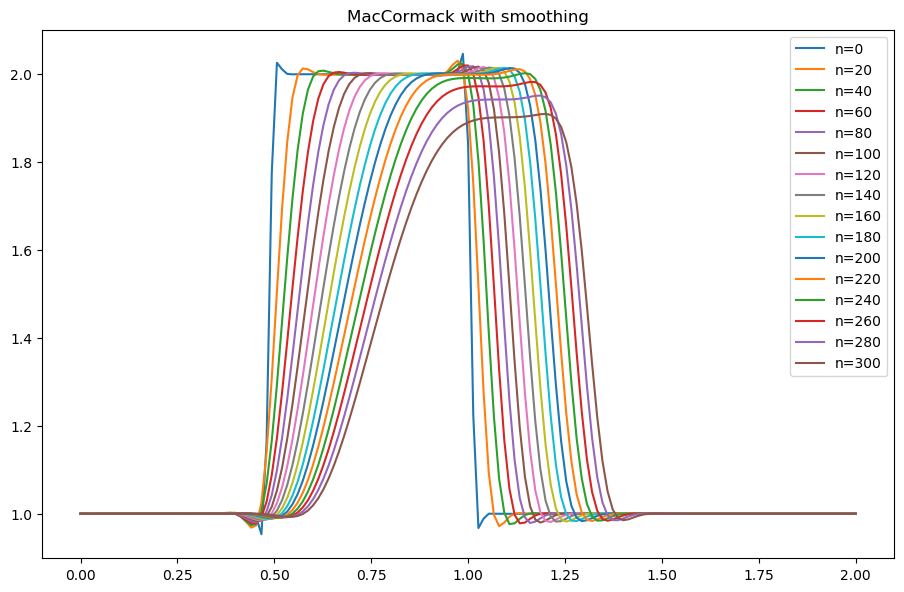

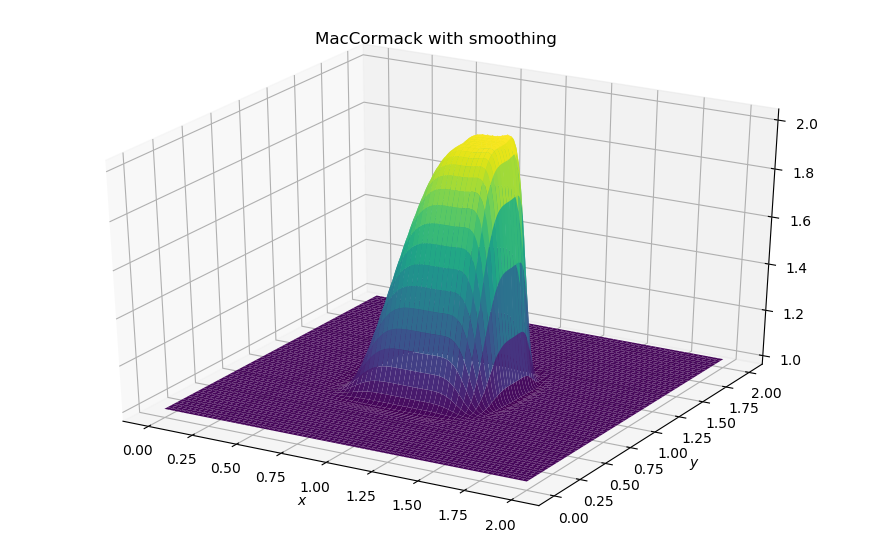

In [112]:
# Evaluate MacCormack method with smoothing
u, v = initialize(nx, ny, dx, dy)
u3, v3 = maccormack2(u, v, dt, dx, dy, nt)
plot2d(x, y, u, 'MacCormack with smoothing')

Text(0, 0.5, '$u$')

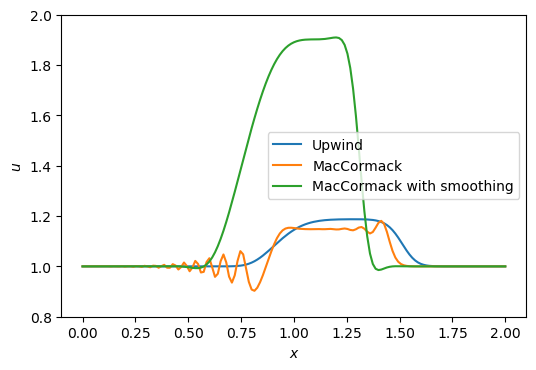

In [113]:
# Compare solution at y = 1.4
fig = plt.figure(figsize=(6, 4), dpi=100)
plt.plot(x,u1[70,:],label='Upwind')
plt.plot(x,u2[70,:],label='MacCormack')
plt.plot(x,u3[70,:],label='MacCormack with smoothing')
plt.legend()
plt.ylim((0.8,2))
plt.xlabel('$x$')
plt.ylabel('$u$')

We see that the addition of smoothing has significantly improved the solution. The high-frequency oscillations are eliminated and the solution is not nearly as dissipated as compared to the upwind or unsmoothed MacCormack method.

### Effect of differencing direction in predictor/corrector steps

The receeding discontinuity on the trailing end of the wave is smeared out and not as sharply-resolved as the leading discontinuity. This is probably because the predictor and corrector steps consistently use forwards and backwards differences, respectively. If we alternated the direction of forwards and backwards differences in the predictor and corrector steps, we may be able to improve the solution further.  We will alternate as follows:

| $\Delta t$ | Predictor | Corrector |
| -----------|-----------|-----------|
| Even | FD | BD |
| Odd  | BD | FD |

In [114]:
def maccormack3(u,v,dt,dx,dy,nt):
    # This function solves 2D inviscid Burgers equation in 2D using
    # MacCormack method. It takes 5 arguments: the initial u and v arrays,
    # time step size, x spatial step size dx, y spatial step size dy, and
    # number of time steps to integrate. It differs from the above in that it
    # alternates the direction of the finite differences in the predictor and 
    # corrector steps on alternating time steps.
    fig = plt.figure(figsize=(11, 7), dpi=100)    
    plt.title('MacCormack2')
    
    eps = 0.05
    
    # loop across time steps
    for n in range (nt + 1):
        up = u.copy()
        vp = v.copy()
        
        F = 0.5*u.copy()**2
        G = 0.5*u.copy()*v.copy()
        H = 0.5*v.copy()**2
        
        if (n % 2 == 0): # even time steps. FD in predictor; BD in corrector
            up[1:-1,1:-1] = u[1:-1,1:-1] - dt/dx*(F[1:-1,2:]-F[1:-1,1:-1]) - dt/dy*(G[2:,1:-1]-G[1:-1,1:-1]) 
            vp[1:-1,1:-1] = v[1:-1,1:-1] - dt/dx*(G[1:-1,2:]-G[1:-1,1:-1]) - dt/dy*(H[2:,1:-1]-H[1:-1,1:-1])
        
            # add smoothing
            up[2:-2,2:-2] = u[2:-2,2:-2] - eps*(u[2:-2,4:] - 4*u[2:-2,3:-1] + 6*u[2:-2,2:-2] - 4*u[2:-2,1:-3] + u[2:-2,:-4]
                                          + u[4:,2:-2] - 4*u[3:-1,2:-2] + 6*u[2:-2,2:-2] - 4*u[1:-3,2:-2] + u[:-4,2:-2])
            vp[2:-2,2:-2] = v[2:-2,2:-2] - eps*(v[2:-2,4:] - 4*v[2:-2,3:-1] + 6*v[2:-2,2:-2] - 4*v[2:-2,1:-3] + v[2:-2,:-4]
                                          + v[4:,2:-2] - 4*v[3:-1,2:-2] + 6*v[2:-2,2:-2] - 4*v[1:-3,2:-2] + v[:-4,2:-2])
        
            Fp = 0.5*up.copy()**2
            Gp = 0.5*up.copy()*vp.copy()
            Hp = 0.5*vp.copy()**2
            u[1:-1,1:-1] = 0.5*(u[1:-1,1:-1]+up[1:-1,1:-1] - dt/dx*(Fp[1:-1,1:-1]-Fp[1:-1,0:-2]) - dt/dy*(Gp[1:-1,1:-1]-Gp[0:-2,1:-1]))
            v[1:-1,1:-1] = 0.5*(v[1:-1,1:-1]+vp[1:-1,1:-1] - dt/dx*(Gp[1:-1,1:-1]-Gp[1:-1,0:-2]) - dt/dy*(Hp[1:-1,1:-1]-Hp[0:-2,1:-1]))
        
            # add smoothing
            u[2:-2,2:-2] = u[2:-2,2:-2] - eps*(u[2:-2,4:] - 4*u[2:-2,3:-1] + 6*u[2:-2,2:-2] - 4*u[2:-2,1:-3] + u[2:-2,:-4]
                                          + u[4:,2:-2] - 4*u[3:-1,2:-2] + 6*u[2:-2,2:-2] - 4*u[1:-3,2:-2] + u[:-4,2:-2])
            v[2:-2,2:-2] = v[2:-2,2:-2] - eps*(v[2:-2,4:] - 4*v[2:-2,3:-1] + 6*v[2:-2,2:-2] - 4*v[2:-2,1:-3] + v[2:-2,:-4]
                                          + v[4:,2:-2] - 4*v[3:-1,2:-2] + 6*v[2:-2,2:-2] - 4*v[1:-3,2:-2] + v[:-4,2:-2])        
        else: # odd time steps. BD in predictor; FD in corrector
            
            up[1:-1,1:-1] = u[1:-1,1:-1] - dt/dx*(F[1:-1,1:-1]-F[1:-1,0:-2]) - dt/dy*(G[1:-1,1:-1]-G[0:-2,1:-1]) 
            vp[1:-1,1:-1] = v[1:-1,1:-1] - dt/dx*(G[1:-1,1:-1]-G[1:-1,0:-2]) - dt/dy*(H[1:-1,1:-1]-H[0:-2,1:-1])
        
            # add smoothing
            up[2:-2,2:-2] = u[2:-2,2:-2] - eps*(u[2:-2,4:] - 4*u[2:-2,3:-1] + 6*u[2:-2,2:-2] - 4*u[2:-2,1:-3] + u[2:-2,:-4]
                                          + u[4:,2:-2] - 4*u[3:-1,2:-2] + 6*u[2:-2,2:-2] - 4*u[1:-3,2:-2] + u[:-4,2:-2])
            vp[2:-2,2:-2] = v[2:-2,2:-2] - eps*(v[2:-2,4:] - 4*v[2:-2,3:-1] + 6*v[2:-2,2:-2] - 4*v[2:-2,1:-3] + v[2:-2,:-4]
                                          + v[4:,2:-2] - 4*v[3:-1,2:-2] + 6*v[2:-2,2:-2] - 4*v[1:-3,2:-2] + v[:-4,2:-2])
        
            Fp = 0.5*up.copy()**2
            Gp = 0.5*up.copy()*vp.copy()
            Hp = 0.5*vp.copy()**2
            u[1:-1,1:-1] = 0.5*(u[1:-1,1:-1]+up[1:-1,1:-1] - dt/dx*(Fp[1:-1,2:]-Fp[1:-1,1:-1]) - dt/dy*(Gp[2:,1:-1]-Gp[1:-1,1:-1]))
            v[1:-1,1:-1] = 0.5*(v[1:-1,1:-1]+vp[1:-1,1:-1] - dt/dx*(Gp[1:-1,2:]-Gp[1:-1,1:-1]) - dt/dy*(Hp[2:,1:-1]-Hp[1:-1,1:-1]))
        
            # add smoothing
            u[2:-2,2:-2] = u[2:-2,2:-2] - eps*(u[2:-2,4:] - 4*u[2:-2,3:-1] + 6*u[2:-2,2:-2] - 4*u[2:-2,1:-3] + u[2:-2,:-4]
                                          + u[4:,2:-2] - 4*u[3:-1,2:-2] + 6*u[2:-2,2:-2] - 4*u[1:-3,2:-2] + u[:-4,2:-2])
            v[2:-2,2:-2] = v[2:-2,2:-2] - eps*(v[2:-2,4:] - 4*v[2:-2,3:-1] + 6*v[2:-2,2:-2] - 4*v[2:-2,1:-3] + v[2:-2,:-4]
                                          + v[4:,2:-2] - 4*v[3:-1,2:-2] + 6*v[2:-2,2:-2] - 4*v[1:-3,2:-2] + v[:-4,2:-2]) 
        u[0,:] = 1
        u[-1,:] = 1
        u[:,0] = 1
        u[:,-1] = 1
        v[0,:] = 1
        v[-1,:] = 1
        v[:,0] = 1
        v[:,-1] = 1
        
        if (n % 20 == 0):
            string = 'n=' + str(n)
            plt.plot(x,u[70,:],label=string)
            plt.legend()
        
    return u, v

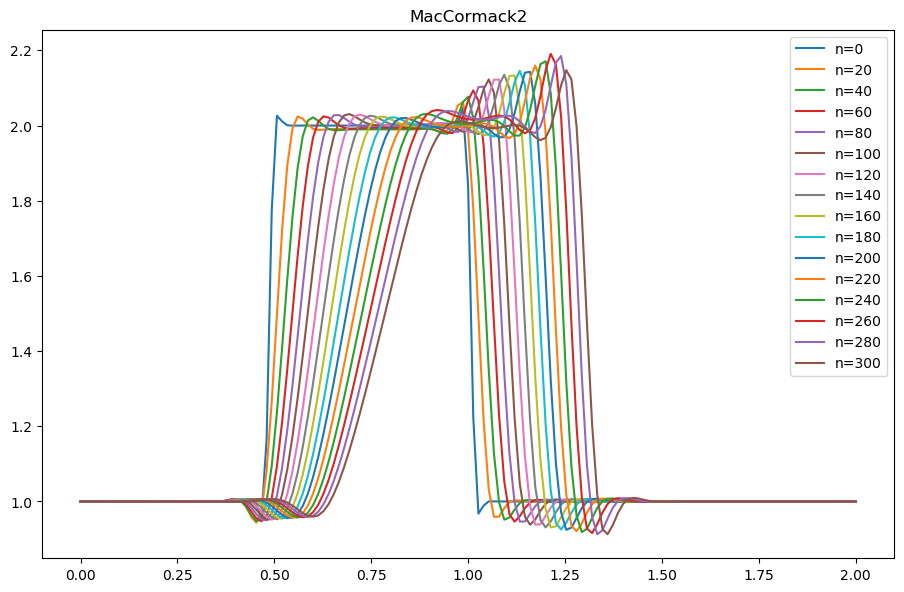

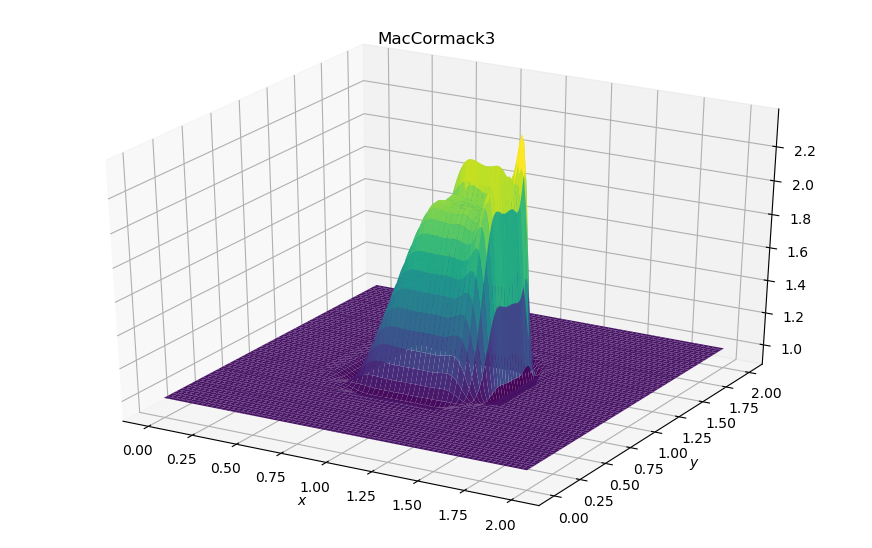

In [117]:
# Evaluate MacCormack method with smoothing and alternating differencing
u, v = initialize(nx, ny, dx, dy)
u4, v4 = maccormack3(u, v, dt, dx, dy, nt)
plot2d(x, y, u4, 'MacCormack3')

Compare solutions at $y$ = 1.4:

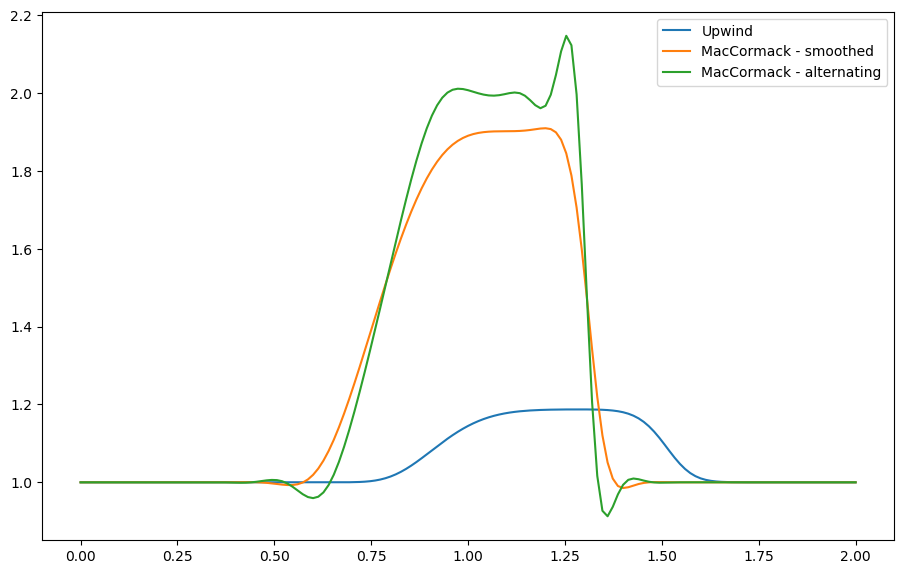

In [116]:
fig = plt.figure(figsize=(11, 7), dpi=100)
plt.plot(x,u1[70,:],label='Upwind')
plt.plot(x,u3[70,:],label='MacCormack - smoothed')
plt.plot(x,u4[70,:],label='MacCormack - alternating')
plt.legend()

When the differencing direction is alternated, some of the dispersion error returns, but it remains bounded. However, there is much lower dissipation--the $u=2$ amplitude is retained and both the leading and trailing discontinuities are resolved much more sharply.